# Aufgabe 3: Cross Validation und Grid Search

In dieser Aufgabe geht es um Hyperparameter-Optimierung mittels _Grid-Search_ (deutsch: Gittersuche). Dabei handelt es sich um eine Brute-Force-Suche, die auf einen angegebenen Teil des Hyperparameterraums angewandt wird. Sie wird dabei von einer Performance-Metrik geleitet.

Die Gittersuche soll in diesem Notebook auf zwei verschiedene Klassifikationsaufgaben angewandt werden, wobei die Anzahl der verwendeten CPU-Kerne variiert werden soll:

- Iris Flower Dataset
- Heart Disease UCI Dataset

Anschließend soll für beide Aufgaben jeweils eine Kurve mit der Suchzeit in Abhängigkeit von der Anzahl an CPU- Kernen geplottet werden. Außerdem soll die Zielmetrik in Abhängigkeit von einem ausgewählten Hyperparameter geplottet werden.

In [Aufgabe 5](./Exercise5.ipynb) soll diese Aufgabe zudem im Batch-System des SDIL ausgeführt werden. Aus diesem Grund wird in diesem Notebook darauf geachtet, dass es ohne Probleme in ein auführbares Python-Skript konvertiert werden kann.

## Bibliotheken Importieren

Importieren der Bibliotheken. Beim Importieren von `matplotlib` muss darauf geachtet werden, das `agg`-Backend zu verwenden, wenn der Code nicht in einem Notebook ausgeführt wird, da es sonst zu Fehlern kommt.

In [1]:
## Import Libraries

# Technical
import time
import multiprocessing
import sys
from tqdm import tqdm

# Typical
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import datasets

# Classifiers
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Matplotlib
if not 'ipykernel' in sys.modules:
    # Prevents errors when plotting outside Jupyter Notebook
    # For more information see exercise 5
    import matplotlib
    matplotlib.use('agg')
import matplotlib.pyplot as plt

## Funktions-Definitionen

Um bei der Gittersuche einfach die Anzahl der CPU-Kerne variieren zu können, wird zunächst eine Funktion definiert, welche die Gittersuche (`GridSearchCV`) in einer `for`-Schleife mit einer jeweils anderen Anzahl an CPU-Kernen ausführt.

In [2]:
def grid_search_with_cores(classifier, param_grid, X_train, y_train, core_range=None):
    """Instanciates `sklearn.model_selection.GridSearchCV` with given classifier/param_grid 
    and fits it on the given training data. This is done multiple times with different number of CPU cores.
    The numbers for CPU cores can be given with the core_range parameter.
    
    During computation, a progress bar is shown.
    
    Returns
    -------
    times : pandas.DataFrame
            Contains the time needed to train with the different numbers of CPU cores.
    grid_search: sklearn.model_selection.GridSearchCV
            Reference to one of the fitted grid search models.
    """
    
    # If no core range is given, take all possible values
    if core_range is None:
        core_range = list(range(1, multiprocessing.cpu_count()+1))
        
    # Instanciate DataFrame for saving the training times
    times = pd.DataFrame(columns=['n_cores', 'times'])

    # Show progress bar with tqdm
    for n in tqdm(core_range):
        # Instanciate Grid Search
        grid_search = GridSearchCV(classifier, param_grid, n_jobs=n)

        # Start time measurement
        start = time.time()

        # Modell trainieren
        grid_search.fit(X_train, y_train)

        # End time measurement
        end = time.time()

        # Append results
        times = times.append(pd.DataFrame.from_dict({'n_cores': [n], 'times': [end - start]}))

    # Return times Dataframe and reference to the last GridSearchCV object
    return times, grid_search

Als nächstes definieren wir eine Funktion zum Plotten der Kurve mit der Suchzeit in Abhängigkeit von der Anzahl an CPU- Kernen:

In [3]:
def plot_times(times):
    """Plots the times returned by grid_search_with_cores"""
    # Create the plot
    plot = times.plot(x='n_cores', y='times', legend=False)
    # Set plot labels
    plot.set(xlabel="#Cores", ylabel="Time in seconds")

Zum Schluss definieren wir noch eine Funktion zum Plotten der Zielmetrik in Abhängigkeit von einem (bzw. zwei) ausgewählten Hyperparametern.

In [4]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    """ Plots the mean test score from the information of `GridSearchCV.cv_results_` for two given grid parameters.
    
    Source: https://stackoverflow.com/a/43645640/6853900"""
    
    # Get Test Scores Mean for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    # Beautify the Plot (title, labels, legend, grid)
    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

## Iris Flower Dataset

###### Laden und Vorbereiten des Datensatzes

Siehe [Aufgabe 1](./Exercise1.ipynb) für mehr Details.

In [5]:
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
iris = pd.read_csv(url, names=names)

In [6]:
iris.shape

(150, 5)

In [7]:
# Split-out validation dataset like in the SDIL-Tutorial for comparability
array = iris.values
X = array[:,0:4]
Y = array[:,4]
test_size = 0.20
seed = 7
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)

###### Ausführen der Gittersuche

Als Optimierungsparameter wurden die Parameter `C` und `kernel` gewählt.

In [8]:
# Hyper-Parameter Space
grid_iris = {'C':[1,5,10, 50], 'kernel':['linear','rbf']}

# SVM als Klassifikator
svc = svm.SVC(random_state=0)

times_iris, search_iris = grid_search_with_cores(svc, grid_iris, X_train, y_train, core_range=range(1,33))

100%|██████████| 32/32 [00:13<00:00,  1.57it/s]


###### Plot der Suchzeit in Abhängigkeit von der Anzahl an CPU- Kernen

In [9]:
print(times_iris)

  n_cores     times
0       1  0.056372
0       2  0.198149
0       3  0.215215
0       4  0.238222
0       5  0.249276
0       6  0.247212
0       7  0.255569
0       8  0.267451
0       9  0.282196
0      10  0.301782
0      11  0.305813
0      12  0.427251
0      13  0.329509
0      14  0.349344
0      15  0.375184
0      16  0.370615
0      17  0.386361
0      18  0.498468
0      19  0.519376
0      20  0.414832
0      21  0.481369
0      22  0.601207
0      23  0.467253
0      24  0.480249
0      25  0.501606
0      26  0.505887
0      27  0.580526
0      28  0.538365
0      29  0.628541
0      30  0.718981
0      31  0.586326
0      32  0.703517


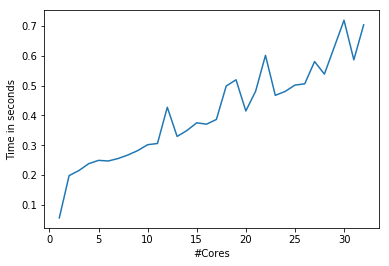

In [10]:
plot_times(times_iris)

Es ist zu erkennen, dass höhere Werte für `n_jobs` in diesem Fall nicht zu kürzeren Ausführungszeiten führen.  
Das könnte daran liegen, dass in der gespawnten Umgebung nur ein Prozessor zur Verfügung steht.

###### Plot der Zielmetrik in Abhängigkeit vom Hyperparameter `C`

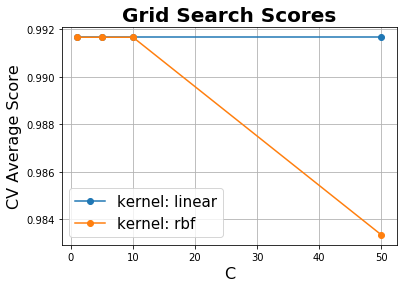

In [11]:
plot_grid_search(search_iris.cv_results_, grid_iris['C'], grid_iris['kernel'], 'C', 'kernel')

###### Validierung auf den Test-Daten

Zum Schluss soll die Performance des von der Gittersuche als besten identifizierten Klassifikators auf den Test-Daten ermittelt werden.

In [12]:
# Print the best estimator
search_iris.best_estimator_

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [13]:
# Predict with the best estimator and print the results
predictions = search_iris.best_estimator_.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))

0.9666666666666667
[[ 7  0  0]
 [ 0 11  1]
 [ 0  0 11]]


Dieses Ergebnis ist leicht besser als das Ergebnis des Klassifikators aus Aufgabe 1, welcher eine Accuracy von `0.93` auf den selben Testdaten hatte.

## Heart Disease UCI Dataset

Dieser Datensatz wurde auf [Kaggle](https://www.kaggle.com/ronitf/heart-disease-uci) gefunden.

Er enthält von 303 Patienten jeweils 14 Attribute und die Information darüber, ob sie eine Herzkrankheit haben oder nicht.

Die ursprüngliche Quelle für den Datensatz ist das [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease).

###### Laden und Vorbereiten des Datensatzes

Die folgenden Zellen zum Laden und VOrverarbeiten der Daten sind zum Teil aus dem Kaggle Notebook "[What Causes Heart Disease?](https://www.kaggle.com/tentotheminus9/what-causes-heart-disease-explaining-the-model)" entnommen.

In [14]:
heart = pd.read_csv("./data/heart.csv")

In [15]:
heart.shape

(303, 14)

In [16]:
heart.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 
                 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved', 'exercise_induced_angina',
                 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

In [17]:
heart['sex'] = heart['sex'].astype('object')
heart['chest_pain_type'] = heart['chest_pain_type'].astype('object')
heart['fasting_blood_sugar'] = heart['fasting_blood_sugar'].astype('object')
heart['rest_ecg'] = heart['rest_ecg'].astype('object')
heart['exercise_induced_angina'] = heart['exercise_induced_angina'].astype('object')
heart['st_slope'] = heart['st_slope'].astype('object')
heart['thalassemia'] = heart['thalassemia'].astype('object')

In [18]:
heart = pd.get_dummies(heart, drop_first=True)

In [19]:
heart.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_1,chest_pain_type_1,chest_pain_type_2,chest_pain_type_3,fasting_blood_sugar_1,rest_ecg_1,rest_ecg_2,exercise_induced_angina_1,st_slope_1,st_slope_2,thalassemia_1,thalassemia_2,thalassemia_3
0,63,145,233,150,2.3,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0
1,37,130,250,187,3.5,0,1,1,0,1,0,0,1,0,0,0,0,0,1,0
2,41,130,204,172,1.4,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0
3,56,120,236,178,0.8,0,1,1,1,0,0,0,1,0,0,0,1,0,1,0
4,57,120,354,163,0.6,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0


In [20]:
#split the data
X_train, X_test, y_train, y_test = model_selection.train_test_split(heart.drop('target', 1), heart['target'], test_size = .2, random_state=0) 

###### Ausführen der Gittersuche

Als Optimierungsparameter wurden die Parameter `n_estimators` und `max_features` gewählt.

In [21]:
# Hyper-Parameter Space
grid_heart = {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)],
              'max_features': ['auto', 'sqrt']}

# SVM als Klassifikator
clf = RandomForestClassifier(random_state=0)

times_heart, search_heart = grid_search_with_cores(clf, grid_heart, X_train=X_train, y_train=y_train, core_range=range(1,33))

100%|██████████| 32/32 [27:12<00:00, 51.29s/it]


###### Plot der Suchzeit in Abhängigkeit von der Anzahl an CPU- Kernen

In [22]:
print(times_heart)

  n_cores      times
0       1  48.982619
0       2  50.495949
0       3  50.225746
0       4  50.027375
0       5  51.140501
0       6  50.152092
0       7  50.759058
0       8  50.009245
0       9  50.017489
0      10  51.368298
0      11  52.987426
0      12  50.995118
0      13  51.082073
0      14  51.873379
0      15  50.786849
0      16  51.408982
0      17  52.332782
0      18  50.853854
0      19  51.750174
0      20  50.463087
0      21  51.465090
0      22  51.242620
0      23  52.080635
0      24  50.628146
0      25  50.208746
0      26  50.515572
0      27  51.920690
0      28  50.450451
0      29  51.833144
0      30  51.190635
0      31  51.335224
0      32  51.371176


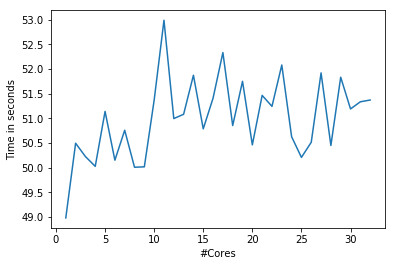

In [23]:
plot_times(times_heart)

Auch in diesem Fall führen höhere Werte für `n_jobs` nicht zu kürzeren Ausführungszeiten, jedoch haben höhere Werte nicht so starke Auswirkungen wie beim kleineren Iris-Datensatz.

###### Plot der Zielmetrik in Abhängigkeit vom Hyperparameter `n_estimators`

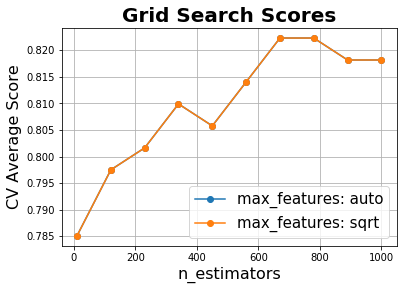

In [24]:
plot_grid_search(search_heart.cv_results_, grid_heart['n_estimators'], grid_heart['max_features'], 'n_estimators', 'max_features')

###### Validierung auf den Test-Daten

Zum Schluss soll die Performance des von der Gittersuche als besten identifizierten Klassifikators auf den Test-Daten ermittelt werden.

In [25]:
# Print the best estimator
search_heart.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=670, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [26]:
# Predict with the best estimator and print the results
predictions = search_heart.best_estimator_.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))

0.8360655737704918
[[22  5]
 [ 5 29]]
